In [3]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn as sk
from sklearn import metrics

# para UMAP
import umap
import umap.plot

import gower # calcula matriz de distancias gower
import fastcluster # mejora la performance del cluster jerárquico

# https://genieclust.gagolewski.com/
# https://doi.org/10.1016/j.softx.2021.100722
import genieclust

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import randint
import pandas as pd
import pickle
import seaborn as sns
import time

# trabajo con zip
from zipfile import ZipFile
from io import BytesIO


# from google.colab import drive
# drive.mount('/content/drive')

ModuleNotFoundError: No module named 'umap'

In [ ]:

def grafico_evaluacion(X_train_test, labels_orig, labels_test , nom_test=''):
    '''grafico en el espacio vectorial del pca las clasificaciones realizadas
    X_train_test = coordenadas de lso puntos en PCA -considera slo las primeras 4-
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo
    nom_test     = texto para aclara en el grafico el nombre del clasificador utilizado
    '''
    
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab20(np.arange(5)), 5)

    fig, axs = plt.subplots(2,2)
    axs[0,0].scatter(X_train_test[:,0],X_train_test[:,1],s=1,c=labels_test, alpha=0.5, cmap=cmap)
    axs[0,0].set_xlabel('PC1')
    axs[0,0].set_ylabel('PC2')
    axs[0,1].scatter(X_train_test[:,2],X_train_test[:,3],s=1,c=labels_test, alpha=0.5, cmap=cmap)
    axs[0,1].set_xlabel('PC3')
    axs[0,1].set_ylabel('PC4')
    
    
    axs[1,0].scatter(X_train_test[:,0],X_train_test[:,1],s=1,c=labels_orig, alpha=0.5, cmap=cmap)
    axs[1,0].set_xlabel('PC1')
    axs[1,0].set_ylabel('PC2')
    axs[1,1].scatter(X_train_test[:,2],X_train_test[:,3],s=1,c=labels_orig, alpha=0.5, cmap=cmap)
    axs[1,1].set_xlabel('PC3')
    axs[1,1].set_ylabel('PC4')
    
    
    axs[0,0].set_title(f'{nom_test}')
    axs[0,1].set_title(f'{nom_test}')
    axs[1,0].set_title('real')
    axs[1,1].set_title('real')
    fig.set_constrained_layout('constrained')
    return None

def cross_tab(Labels_orig, Labels_clust):
    '''crea matriz de confusión para evaluar etiquetado
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo'''
    tmp = pd.DataFrame({'Labels_orig': Labels_orig, 'Labels_clust': Labels_clust})
    ct = pd.crosstab(tmp['Labels_clust'],tmp['Labels_orig']) # Create crosstab: ct
    rand = metrics.rand_score(Labels_orig, Labels_clust)
    arand= metrics.adjusted_rand_score(Labels_orig, Labels_clust)
    print(f'RAND score={rand:.4f}, Ajusted RAND={arand:.4f}, cantidad_de_muestras={len(Labels_orig):,d}')
    return ct


In [2]:
def leo_y_consolido_features(input_path='./input/'):
    df1 = pd.read_csv(input_path+'features_Arborio.csv')
    df2 = pd.read_csv(input_path+'features_Basmati.csv')
    df3 = pd.read_csv(input_path+'features_Ipsala.csv')
    df4 = pd.read_csv(input_path+'features_Jasmine.csv')
    df5 = pd.read_csv(input_path+'features_Karacadag.csv')
    features = np.array(pd.concat([df1,df2,df3,df4,df5], axis =0))
    return features
    
def paso_a_pca(features, guardo=False, archivo_guarda=None):
    # reduce the amount of dimensions in the feature vector
    pca = PCA(n_components=100, random_state=22)
    pca.fit(features)
    x = pca.transform(features)
    if guardo:
        archivo_pca = archivo_guarda
        pd.DataFrame(x).to_csv(archivo_pca, index=False)
    # grafico varianza explicada
    ax = plt.subplot()
    ax.plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
    ax.set_xlim([0,15])
    ax.set_xlabel('PCs')
    ax.set_ylabel('Var. explicada (%)')
    return x

ARCHIVO_PCA = 'C:/Users/jfgonzalez/Documents/Documentación_maestría/Ciencia_y_tecnologia/feat_pca.csv'
INPUT_P = 'C:/Users/jfgonzalez/Documents/Documentación_maestría/Ciencia_y_tecnologia/unsupervised-rice-image-segmentation/input/'

# x = paso_a_pca(leo_y_consolido_features(input_path=INPUT_P),
#                guardo=True, archivo_guarda=ARCHIVO_PCA)

x = pd.read_csv(ARCHIVO_PCA).to_numpy()

NameError: name 'pd' is not defined

In [4]:
# divido dataset hay que considerar el tamaño según el método porque algunos toman mucho tiempo


# como están ordenadas por clase voy a hacer una lista con las etiquetas ahora antes de mezclarlas
clases_dict = {0:'Arborio', 1:'Basmati', 2:'Ipsala', 3:'Jasmine', 4:'Karacadag'}
lista_clases = ([0]*15000 + [1]*15000 + [2]*15000 + [3]*15000 + [4]*15000)


# separo en train_test y validación con sus respectivas etiquetas y los mezclo
X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(x, lista_clases, test_size=0.2, random_state=42)

org_lab = pd.Series(y_train_test).map(clases_dict)

In [5]:
del x, X_val, y_val, lista_clases

RAND score=0.8062, Ajusted RAND=0.3988, cantidad_de_muestras=60,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,1693,0,222,6,10400
1,915,2339,4933,4473,8
2,1790,34,5409,2384,160
3,7559,3,1340,189,1503
4,46,9629,13,4952,0


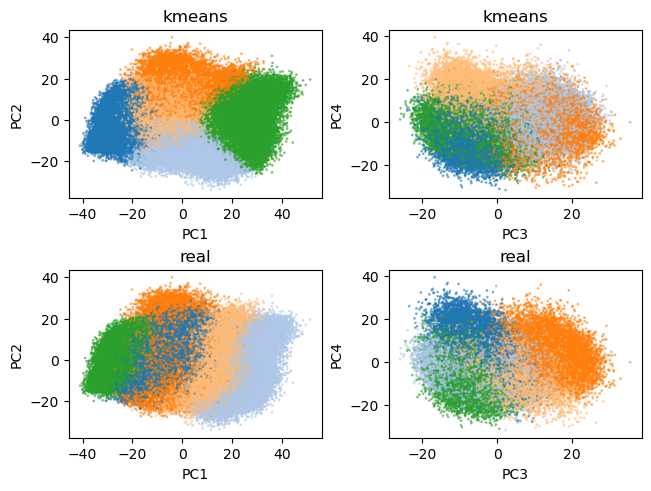

In [6]:
# aplico kmeans, esto porque es rápido y me sirve de punto de comparación


#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans = KMeans(n_clusters=5, n_init='auto')
kmeans.fit(X_train_test)


grafico_evaluacion(X_train_test, y_train_test, kmeans.labels_ , nom_test='kmeans')
cross_tab(org_lab, kmeans.labels_)


RAND score=0.8420, Ajusted RAND=0.5820, cantidad_de_muestras=60,000


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,9019,0,102,39,12053
1,7,0,11712,94,0
2,73,9554,63,11831,0
3,0,2451,0,23,0
4,2904,0,40,17,18


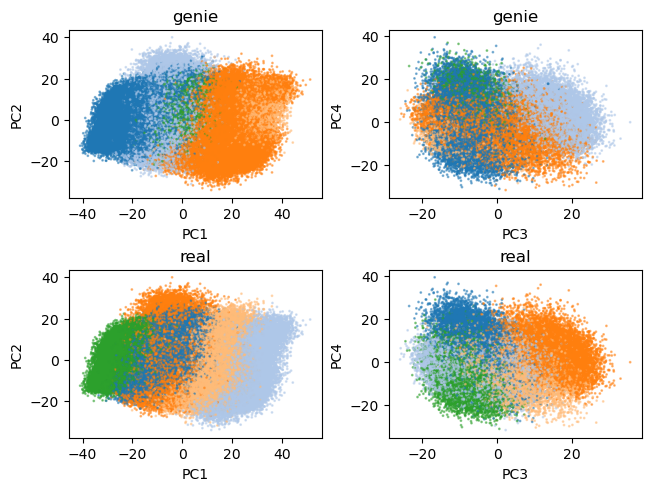

In [7]:
# aplico genieclust (mejora la clasificación con más datos)

g = genieclust.Genie(n_clusters=5)
labels_genie = g.fit_predict(X_train_test)


grafico_evaluacion(X_train_test, y_train_test, labels_genie , nom_test='genie')
cross_tab(org_lab, labels_genie)

In [18]:
# calculo distancias gower
# TARDA MUCHO, OJO CON LA CANTIDAD DE DATOS

#armo matriz de distancias
# en colab cuelga por falta de ram, local funciona
d_meta = gower.gower_matrix(X_train_test)

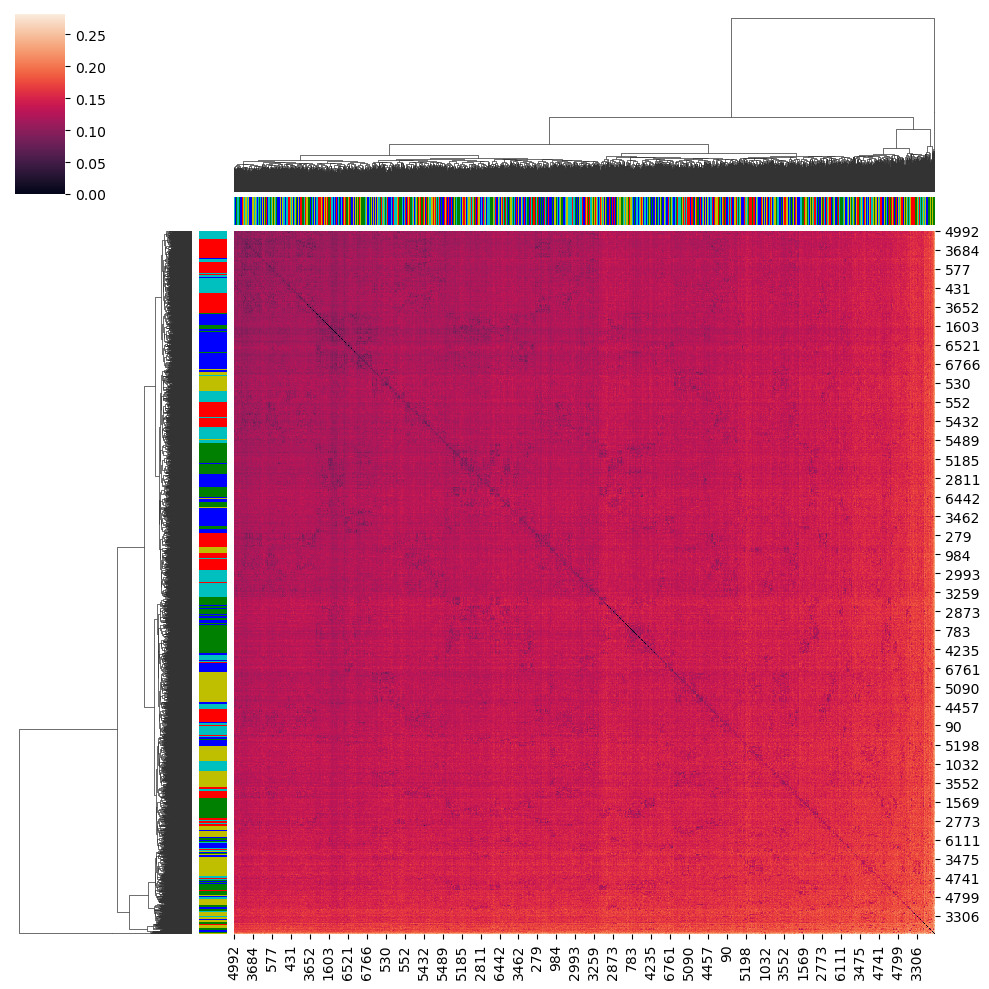

In [19]:
# grafico cluster jerarquico

#esto son colores para ver como comparan estos clusters con los que teníamos armados antes
xval = pd.Series(y_train_test)
lut = dict(zip(xval.unique(), "rbgyc"))
row_colors = xval.map(lut).to_numpy()

xval = pd.Series(kmeans.labels_)
lut = dict(zip(xval.unique(), "rbgyc"))
col_colors = xval.map(lut).to_numpy()

#este paso también TARDA MUCHO porque hace el cluterizado en el gráfico...
mapa_clust = sns.clustermap(d_meta, row_colors=row_colors, col_colors=col_colors)

<Axes: >

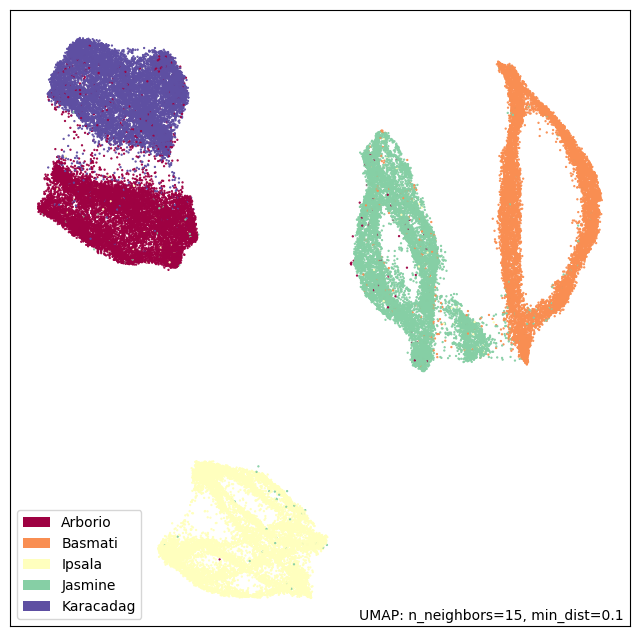

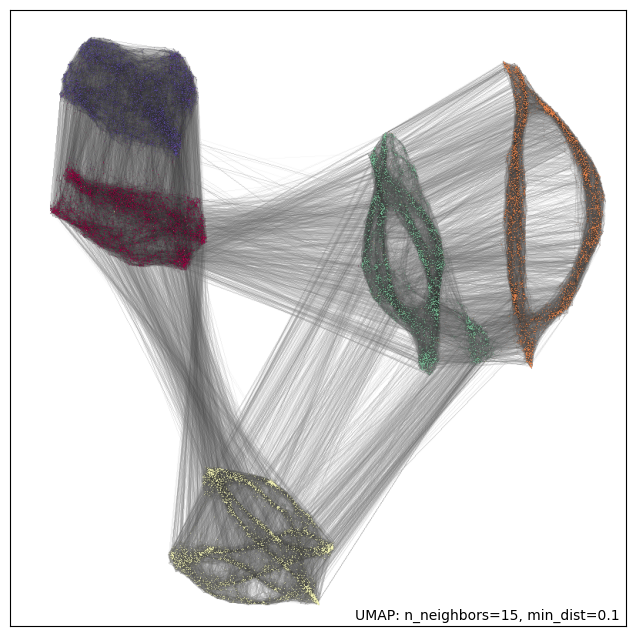

In [8]:
#Realizo UMAP reducción de dimensiones desde pca con UMAP y clasifico

um = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean')
Xred = um.fit_transform(X_train_test)

genie_umap = genieclust.Genie(n_clusters=5).fit_predict(Xred)
kmeans_umap = KMeans(n_clusters=5, n_init='auto').fit_predict(Xred)

umap.plot.points(um, labels=org_lab)
umap.plot.connectivity(um, show_points=True, labels=org_lab)


In [9]:
print('KMEANS', f'n_neighbors=15, min_dist=01, n_components=2')
print(cross_tab(org_lab, kmeans_umap))
print()
print('HCLUST', f'n_neighbors=15, min_dist=01, n_components=2')
print(cross_tab(org_lab, genie_umap))

KMEANS n_neighbors=15, min_dist=01, n_components=2
RAND score=0.9856, Ajusted RAND=0.9550, cantidad_de_muestras=60,000
Labels_orig   Arborio  Basmati  Ipsala  Jasmine  Karacadag
Labels_clust                                              
0                  54      209      41    11812          0
1                 334        0       2        3      11877
2                   1        0   11803       34          0
3                   0    11796       0      122          0
4               11614        0      71       33        194

HCLUST n_neighbors=15, min_dist=01, n_components=2
RAND score=0.9857, Ajusted RAND=0.9553, cantidad_de_muestras=60,000
Labels_orig   Arborio  Basmati  Ipsala  Jasmine  Karacadag
Labels_clust                                              
0               11600        0      71       33        169
1                 348        0       2        3      11902
2                   1        0   11803       34          0
3                  54      207      40    11807      

<Axes: >

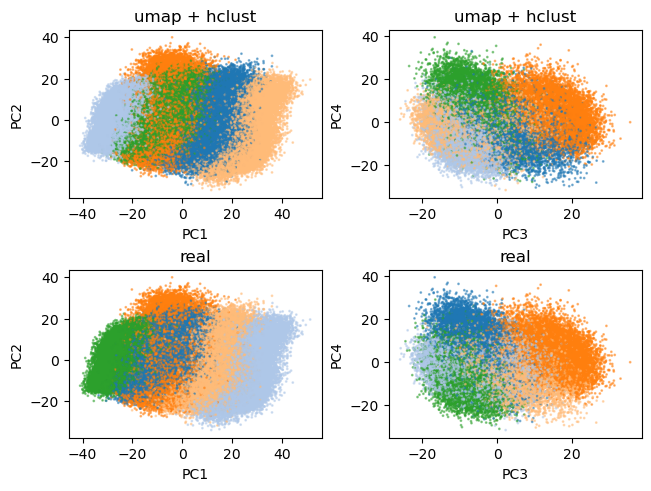

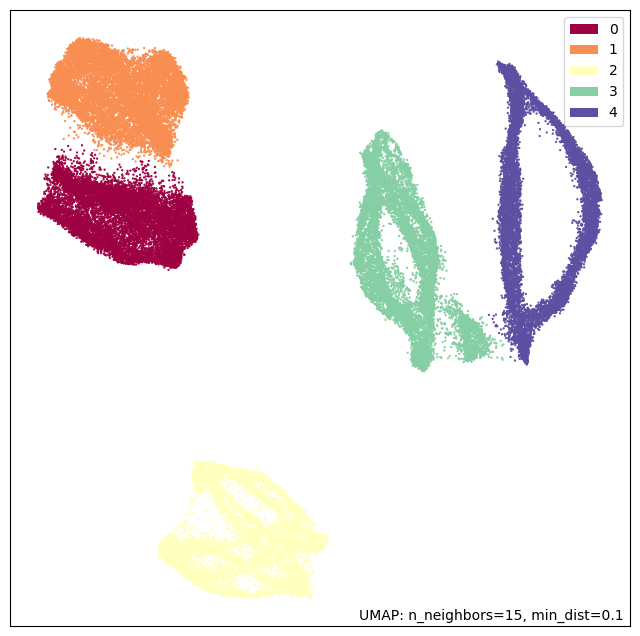

In [10]:
grafico_evaluacion(X_train_test, y_train_test, kmeans_umap , nom_test='umap + hclust')

umap.plot.points(um, labels=genie_umap)